In [1]:
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from MolJuncTree import MolJuncTree

In [2]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

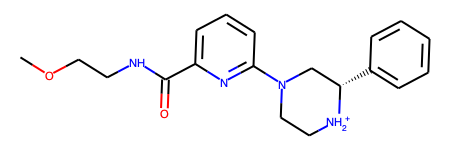

In [7]:
Chem.MolFromSmiles('COCCNC(=O)c1cccc(N2CC[NH2+][C@@H](c3ccccc3)C2)n1')

In [18]:
smiles_batch = ['COCCNC(=O)c1cccc(N2CC[NH2+][C@@H](c3ccccc3)C2)n1']
mols_batch = [Chem.MolFromSmiles(smiles) for smiles in smiles_batch]

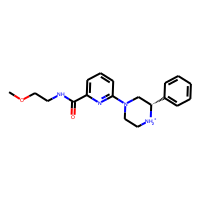

In [19]:
Draw.MolsToGridImage(mols_batch, molsPerRow=1)